In [49]:
import numpy as np
import pandas as pd

import seaborn as sns

features = ['duration','protocol_type','service','flag','src_bytes','dst_bytes','land','wrong_fragment','urgent',
'hot','num_failed_logins','logged_in','num_compromised','root_shell','su_attempted','num_root','num_file_creations',
'num_shells','num_access_files','num_outbound_cmds','is_host_login','is_guest_login','count','srv_count',
'serror_rate','srv_serror_rate','rerror_rate','srv_rerror_rate','same_srv_rate','diff_srv_rate','srv_diff_host_rate',
'dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate','dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate','dst_host_rerror_rate','dst_host_srv_rerror_rate',
'label']

#intrusion_type = ['back','buffer_overflow','ftp_write',
 #'guess_passwd','imap,ipsweep','land,loadmodule',
 #'multihop,neptune','nmap,normal','perl',
 #'phf','pod','portsweep','rootkit',
 #'satan','smurf','spy','teardrop',
 #'warezclient','warezmaster']

In [50]:
data = pd.read_csv('kddcup.data_10_percent', names = features, header=None)
data.drop(data.loc[data['label']=='normal.'].index, inplace=True)



## Converting the label non-dos/dos to 0 and 1

In [51]:
l_dos = ['back.','land.','neptune.','pod.','smurf.','teardrop.']

l_ndos = ['buffer_overflow','ftp_write','guess_passwd','imap','ipsweep','loadmodule','multihop','nmap','perl','phf',
          'portsweep','rootkit','satan','spy','warezclient','warezmaster']


#2 if normal , 0 if non-dos , 1 if dos


data['label'] = data['label'].apply(lambda x: 2 if x == 'normal.' else (1 if (x in l_dos ) else 0))



#df_example = data[['duration', 'dst_host_rerror_rate', 'label']]
#sns.scatterplot(data = data, x ='duration', y = 'dst_host_rerror_rate', hue = 'label')


# Get unique labels : print(data['label'].unique())
# Review the columns which might need integer encoding data.dtypes

In [52]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer

## One Hot Encoding the columns

In [53]:
protocol_end = pd.get_dummies(data.protocol_type)
service_end = pd.get_dummies(data.service)
flag = pd.get_dummies(data.flag)



In [54]:
data_encoded = pd.concat([data,protocol_end,service_end,flag],axis = 'columns')

In [55]:
data_encoded_final = data_encoded.drop(['protocol_type','flag','service'],axis = 'columns')

#data_encoded.drop('service',axis = 'columns')
#data_encoded.drop('flag',axis = 'columns')



## Undersampling the data to removed skewed classes

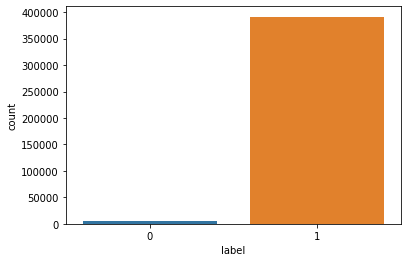

In [56]:
ax = sns.countplot(x='label',data = data_encoded_final)


In [57]:
data_encoded_final['label'].value_counts()

1    391458
0      5285
Name: label, dtype: int64

In [58]:
minority_class_len = len(data_encoded_final[data_encoded_final['label'] == 0])
print(minority_class_len)

5285


In [59]:
majority_class_indices = data_encoded_final[data_encoded_final['label'] == 1].index
print(majority_class_indices)

Int64Index([  7601,   7602,   7793,   7794,   7795,   7796,   7797,   7798,
              7799,   7800,
            ...
            490955, 490956, 490957, 490958, 490959, 490960, 490961, 490962,
            490963, 490964],
           dtype='int64', length=391458)


In [60]:
random_majority_indices = np.random.choice(majority_class_indices,minority_class_len,replace='False')
print(len(random_majority_indices))

5285


In [61]:
minority_class_indices = data_encoded_final[data_encoded_final['label'] == 0].index
print(minority_class_indices)


Int64Index([   744,    745,   4049,   4113,  15699,  22750,  22751,  22752,
             22753,  22754,
            ...
            485172, 485173, 485174, 485175, 485176, 485177, 485178, 485179,
            485180, 485181],
           dtype='int64', length=5285)


In [62]:
under_sample_indices = np.concatenate([minority_class_indices,random_majority_indices])

In [63]:
under_sample = data_encoded_final.loc[under_sample_indices]

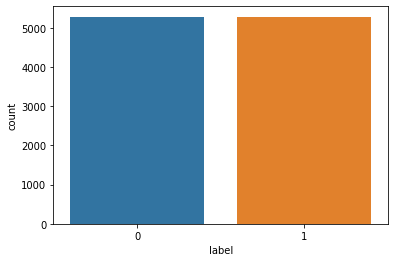

In [64]:
under_sample['label'].value_counts
sns.countplot(x='label',data = under_sample)

## X and y being created

In [65]:
X = under_sample.drop('label',axis = 'columns')
y =  under_sample.label

# validate if X and y have same rows # y.shape

## Test and Training Split and Scaling the data

In [66]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1, stratify=y)


sc = StandardScaler()
sc.fit(X_train)

X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

print('Labels count in y:', np.bincount(y))
print('Labels count in y_train:', np.bincount(y_train))

print('Labels count in y_test:', np.bincount(y_test))


Labels count in y: [5285 5285]
Labels count in y_train: [2643 2642]
Labels count in y_test: [2642 2643]


# SVM Model Training Kernel 

In [67]:
from sklearn import svm
import time

#Create a svm Classifier

clf_linear = svm.SVC(kernel='linear') # Linear Kernel
clf_rbf =  svm.SVC(kernel='rbf') # Gaussian Radial Basis Function
clf_sigmoid =  svm.SVC(kernel='sigmoid') # Sigmoid Kernel
clf_poly =  svm.SVC(kernel='poly') # Polynomial Kernel

## Linear Kernel , Predict Response , Model Report

In [ ]:
#Train the model using the training sets

start_linear = time.time()
clf_linear.fit(X_train, y_train)
stop_linear = time.time()

##### LINEAR Model Report - Accuracy/Precision/Recall of the model   ||| Training and Test Error - #Predict the response for test dataset

In [70]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print(f"Training time: {stop_linear - start_linear}s")

y_pred_linear = clf_linear.predict(X_test)
print('Misclassified examples: %d' % (y_test != y_pred_linear).sum())

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_linear))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_linear))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_linear))

Training time: 407.96166467666626s
Misclassified examples: 3
Accuracy: 0.9994323557237464
Precision: 0.9992435703479576
Recall: 0.9996216420734014


## Sigmoid Kernel , Predict Response , Model Report

In [71]:
#Train the model using the training sets

start_sigmoid = time.time()
clf_sigmoid.fit(X_train_std, y_train)
stop_sigmoid = time.time()

##### SIGMOID Model Report - Accuracy/Precision/Recall of the model   ||| Training and Test Error - #Predict the response for test dataset

In [73]:
#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

print(f"Training time: {stop_sigmoid - start_sigmoid}s")

y_pred_sigmoid = clf_sigmoid.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred_sigmoid).sum())

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_sigmoid))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_sigmoid))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_sigmoid))

Training time: 0.08328700065612793s
Misclassified examples: 26
Accuracy: 0.9950804162724692
Precision: 0.9932152280437241
Recall: 0.9969731365872115


## RBF Kernel , Predict Response , Model Report

In [74]:
#Train the model using the training sets

start_rbf = time.time()
clf_rbf.fit(X_train_std, y_train)
stop_rbf = time.time()

##### RBF Model Report - Accuracy/Precision/Recall of the model   ||| Training and Test Error - #Predict the response for test dataset

In [75]:
print(f"Training time: {stop_rbf - start_rbf}s")

y_pred_rbf = clf_rbf.predict(X_test_std)

print('Misclassified examples: %d' % (y_test != y_pred_rbf).sum())

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_rbf))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_rbf))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_rbf))

Training time: 0.1047811508178711s
Misclassified examples: 26
Accuracy: 0.9950804162724692
Precision: 0.9954562665656949
Recall: 0.9947029890276201


## Poly Kernel , Predict Response , Model Report

In [76]:
#Train the model using the training sets

start_poly = time.time()
clf_poly.fit(X_train_std, y_train)
stop_poly = time.time()

#####  POLY Model Report - Accuracy/Precision/Recall of the model   ||| Training and Test Error - #Predict the response for test dataset

In [77]:
print(f"Training time: {stop_poly - start_poly}s")

y_pred_poly = clf_poly.predict(X_test_std)
print('Misclassified examples: %d' % (y_test != y_pred_poly).sum())

# Model Accuracy: how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(y_test, y_pred_poly))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision:",metrics.precision_score(y_test, y_pred_poly))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall:",metrics.recall_score(y_test, y_pred_poly))

Training time: 0.19844794273376465s
Misclassified examples: 33
Accuracy: 0.993755912961211
Precision: 0.9894973743435859
Recall: 0.9981082103670071


#### Pros and Cons of Kernel

Linear SVM is a parametric model, an RBF kernel SVM isn't, and the complexity of the RBF grows with the size of the training set. 

Not only is it more expensive to train an RBF kernel SVM, but we also have to keep the kernel matrix around, and the projection into this "infinite" higher dimensional space where the data becomes linearly separable is more expensive as well during prediction. 

Furthermore, 23 have more hyperparameters to tune, so model selection is more expensive as well in RBF! And finally, it's much easier to overfit a complex model for RBF!


Poly is less useful for efficiency (computational as well as predictive) performance reasons. 

# Two Feature Sample [under sample]

In [16]:

under_sample_2F = under_sample[['num_failed_logins', 'dst_host_srv_count' ,'label']]
under_sample_2F.head(10)

#num_failed_logins

#dst_host_srv_count

,num_failed_logins,dst_host_srv_count,label
744,0,3,0
745,0,4,0
4049,0,10,0
4113,0,2,0
15699,5,2,0
22750,1,1,0
22751,1,2,0
22752,1,3,0
22753,1,4,0
22754,1,5,0


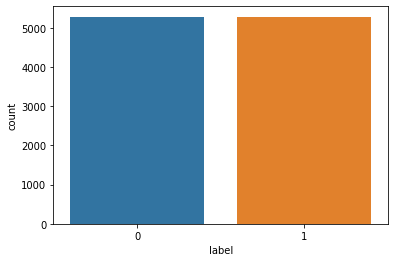

In [17]:
under_sample_2F['label'].value_counts
sns.countplot(x='label',data = under_sample_2F)

In [21]:
X_2F = under_sample_2F.drop('label',axis = 'columns')
y_2F =  under_sample_2F.label

# validate if X and y have same rows # y.shape

#### Two feature train-test split

In [23]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_train_2F, X_test_2F, y_train_2F, y_test_2F = train_test_split(X_2F, y_2F, test_size=0.2, random_state=1, stratify=y_2F)

sc = StandardScaler()
sc.fit(X_train_2F)

X_train_std_2F = sc.transform(X_train_2F)
X_test_std_2F = sc.transform(X_test_2F)

print('Labels count in y:', np.bincount(y_2F))
print('Labels count in y_train:', np.bincount(y_train_2F))

print('Labels count in y_test:', np.bincount(y_test_2F))

Labels count in y: [5285 5285]
Labels count in y_train: [4228 4228]
Labels count in y_test: [1057 1057]


In [24]:
clf_linear_2F = svm.SVC(kernel='linear') # Linear Kernel
clf_rbf_2F =  svm.SVC(kernel='rbf') # Gaussian Radial Basis Function

In [26]:
#Train the model using the training sets

import time

start_linear_2F = time.time()
clf_linear_2F.fit(X_train_std_2F, y_train_2F)
stop_linear_2F = time.time()


start_rbf_2F = time.time()
clf_rbf_2F.fit(X_train_std_2F, y_train_2F)
stop_rbf_2F = time.time()

### Model Report using 2 features.

In [28]:
from sklearn import metrics

print(f"Training time_2F: {stop_linear_2F - start_linear_2F}s")

y_pred_linear_2F = clf_linear_2F.predict(X_test_2F)
print('Misclassified examples_2F: %d' % (y_test_2F != y_pred_linear_2F).sum())

# Model Accuracy: how often is the classifier correct?
print("Accuracy_2F:",metrics.accuracy_score(y_test_2F, y_pred_linear_2F))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision_2F:",metrics.precision_score(y_test_2F, y_pred_linear_2F))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall_2F:",metrics.recall_score(y_test_2F, y_pred_linear_2F))

Training time_2F: 1.6372449398040771s
Misclassified examples_2F: 1057


/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:435: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Accuracy_2F: 0.5
Precision_2F: 0.5
Recall_2F: 1.0


In [29]:
print(f"Training time_2F: {stop_rbf_2F - start_rbf_2F}s")

y_pred_rbf_2F = clf_rbf_2F.predict(X_test_2F)
print('Misclassified examples_2F: %d' % (y_test_2F != y_pred_rbf_2F).sum())

# Model Accuracy: how often is the classifier correct?
print("Accuracy_2F:",metrics.accuracy_score(y_test_2F, y_pred_rbf_2F))

# Model Precision: what percentage of positive tuples are labeled as such?
print("Precision_2F:",metrics.precision_score(y_test_2F, y_pred_rbf_2F))

# Model Recall: what percentage of positive tuples are labelled as such?
print("Recall_2F:",metrics.recall_score(y_test_2F, y_pred_rbf_2F))

Training time_2F: 1.1396150588989258s


/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:435: UserWarning: X has feature names, but SVC was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Misclassified examples_2F: 1573
Accuracy_2F: 0.25591296121097445
Precision_2F: 0.07142857142857142
Recall_2F: 0.04068117313150426


## Plotting the decision boundry for two feature.

Automatically created module for IPython interactive environment


/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"
/Users/samipsinghal/opt/anaconda3/lib/python3.7/site-packages/sklearn/base.py:442: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  "X does not have valid feature names, but"


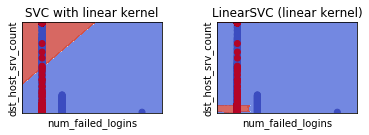

In [48]:
print(__doc__)

import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets

# import some data to play with

X =  X_2F  # we only take the first two features. We could
                      # avoid this ugly slicing by using a two-dim dataset
y =  y_2F

h = .02  # step size in the mesh

# we create an instance of SVM and fit out data. We do not scale our
# data since we want to plot the support vectors

C = 1.0  # SVM regularization parameter

svc = svm.SVC(kernel='linear', C=C).fit(X, y)
rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)


#rbf_svc = svm.SVC(kernel='rbf', gamma=0.7, C=C).fit(X, y)
#poly_svc = svm.SVC(kernel='poly', degree=3, C=C).fit(X, y)
#lin_svc = svm.LinearSVC(C=C).fit(X, y)

# create a mesh to plot in

x_min, x_max = X['num_failed_logins'].min() - 1, X['num_failed_logins'].max() + 1
y_min, y_max = X['dst_host_srv_count'].min() - 1, X['dst_host_srv_count'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))

# title for the plots
titles = ['SVC with linear kernel',
          'LinearSVC (linear kernel)',
          'SVC with RBF kernel',
          'SVC with polynomial (degree 3) kernel']


for i, clf in enumerate((svc,rbf_svc)):
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, x_max]x[y_min, y_max].
    plt.subplot(2, 2, i + 1)
    plt.subplots_adjust(wspace=0.4, hspace=0.4)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

    # Plot also the training points
    plt.scatter(X['num_failed_logins'], X['dst_host_srv_count'], c=y, cmap=plt.cm.coolwarm)
    plt.xlabel('num_failed_logins')
    plt.ylabel('dst_host_srv_count')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.xticks(())
    plt.yticks(())
    plt.title(titles[i])

plt.show()